# gpt2_basic_training_mutliplatform_abstracts
## 2026JAN14


# 0. DETECTION OF GOOGLE DRIVE AND SETUP PATHS  
Some basics for detection of whether using google drive and colaboratory.  
Strong recommend to do this - very easy setup and much faster operation using a GPU (T4 GPU as of January 2026). See README.md for installation instructions.

Inspect the various path variables (PROJECT_ROOT, DATA_DIR, OUTPUT_DIR, SRC_DIR) if there are problems.

In [ ]:
# CELL 1: Optional Google Drive mount (Colab only)
import os
from pathlib import Path

def in_colab() -> bool:
    return "COLAB_GPU" in os.environ or "COLAB_TPU_ADDR" in os.environ or "google.colab" in str(getattr(__import__("sys"), "modules", {}))

IN_COLAB = in_colab()

if IN_COLAB:
    try:
        from google.colab import drive  # type: ignore
        drive.mount("/content/drive")
        print("Mounted Google Drive at /content/drive")
    except Exception as e:
        print(f"Could not mount Google Drive: {e}")
else:
    print("Not running in Colab; skipping Drive mount.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Mounted Google Drive at /content/drive


In [ ]:

# CELL 2: Resolve PROJECT_ROOT (env override > Colab Drive default > search from cwd)
import os
import sys
from pathlib import Path

env_root = os.environ.get("LLM_PROJECT_ROOT", "").strip()
default_colab_root = Path("/content/drive/MyDrive/llm-from-scratch-drive")

def find_repo_root(start: Path) -> Path:
    for p in [start, *start.parents]:
        if (p / "src").exists():
            return p
    return start

if env_root:
    PROJECT_ROOT = Path(env_root).expanduser().resolve()
elif default_colab_root.exists():
    PROJECT_ROOT = default_colab_root.resolve()
else:
    PROJECT_ROOT = find_repo_root(Path.cwd().resolve())

print("CWD:", Path.cwd())
print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC exists:", (PROJECT_ROOT / "src").exists())


CWD: /content
PROJECT_ROOT: /content/drive/MyDrive/llm-from-scratch-drive
SRC exists: True


## 1. package loading

In [ ]:
#import os
#import sys
#from pathlib import Path
#import torch
#import torch.nn as nn
#import tiktoken
#from pathlib import Path
#import torch
#import matplotlib.pyplot as plt
#from matplotlib.ticker import MaxNLocator
#from datetime import datetime
#from torch.utils.data import Dataset, DataLoader
#import json
#from copy import deepcopy

# CELL 3: Imports
import json
from copy import deepcopy
from datetime import datetime

import torch
import torch.nn as nn
import tiktoken

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.utils.data import Dataset, DataLoader



## 2. setup paths for llm package load

In [ ]:

# CELL 4: Paths + sys.path + project imports
SRC_DIR = PROJECT_ROOT / "src"
DATA_DIR = PROJECT_ROOT / "data"
OUTPUT_DIR = PROJECT_ROOT / "output"

# Create output dir if missing (safe)
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("SRC_DIR:", SRC_DIR)
print("DATA_DIR:", DATA_DIR)
print("OUTPUT_DIR:", OUTPUT_DIR)

# Add src to import path (notebook-friendly)
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

# Now your imports work locally or in Colab
from llm_from_scratch.configs import gpt2small_config
from llm_from_scratch.training import training_utils
from llm_from_scratch.models import gpt2
from llm_from_scratch.dataloader import dataloader


SRC_DIR: /content/drive/MyDrive/llm-from-scratch-drive/src
DATA_DIR: /content/drive/MyDrive/llm-from-scratch-drive/data
OUTPUT_DIR: /content/drive/MyDrive/llm-from-scratch-drive/output


## 3. setup run_training()

In [ ]:
def run_training(cfg):
    """Run a single training experiment given a config dict."""

    # timing
    start = datetime.now()

    cfg = deepcopy(cfg)  # avoid in-place mutation
    model_cfg = cfg['model_config']

    # adjust device if cuda not available and cuda was chosen
    device = cfg['device_name']
    print("DEVICE: initial device before adjustment:",device)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("DEVICE: device AFTER adjustment:",str(device))
    cfg['device_name'] = str(device)

    torch.manual_seed(cfg['seed'])
    print(cfg)
    # modify cfg)
    # setup model
    model = gpt2.setup_model(model_cfg)
    model.to(device)
    totparams = sum(p.numel() for p in model.parameters())
    print("Total number of parameters:", totparams)

    # DEBUG: check model
    print("weight_tying flag:", model_cfg["weight_tying"])
    print("same object?:", model.out_head.weight is model.tok_emb.weight)
    print("out_head.weight shape:", model.out_head.weight.shape)
    print("tok_emb.weight shape:", model.tok_emb.weight.shape)


    # tokenizer
    tokenizer = tiktoken.get_encoding(cfg['tokenizer'])

    # dataloaders
    train_loader, val_loader, test_loader = dataloader.generate_data_loaders(cfg)
    print("Show train_loader first entry (converted to text):")
    dataloader.loader_text_examine(train_loader, 0, tokenizer)
    print("Show val_loader first entry (converted to text):")
    dataloader.loader_text_examine(val_loader, 0, tokenizer)
    if test_loader is not None:
        print("Show test_loader first entry (converted to text):")
        dataloader.loader_text_examine(test_loader, 0, tokenizer)

    # DEBUG: check
    # get one batch
    # input_batch, target_batch = next(iter(train_loader))
    # input_batch = input_batch.to(device)
    # target_batch = target_batch.to(device)

    # with torch.no_grad():
    #     logits = model(input_batch)

    # print("tok_emb weight: mean, std:",
    #     model.tok_emb.weight.mean().item(),
    #     model.tok_emb.weight.std().item())
    # print("out_head weight: mean, std:",
    #     model.out_head.weight.mean().item(),
    #     model.out_head.weight.std().item())

    # print("embeds std:", model.tok_emb(input_batch).std().item())
    # print("logits: mean, std, min, max:",
    #     logits.mean().item(),
    #     logits.std().item(),
    #     logits.min().item(),
    #     logits.max().item())

    # evaluation before running code
    before_res = training_utils.eval_full_sets(model, train_loader, val_loader, device, do_train=True)
    print("BEFORE TRAINING:")
    print("training full set loss:", before_res[0])
    print("validation full set loss:", before_res[1])



    # training loop


    # training loop
    model.train()
    num_epochs = cfg['num_epochs']
    optimizer = training_utils.setup_optimizer(model, cfg)
    train_losses, val_losses, tokens_seen, global_step = training_utils.train_model_simple(
        model=model,
        cfg=cfg,
        train_loader=train_loader,
        val_loader=val_loader,
        optimizer=optimizer,
        device=cfg['device_name'],
        num_epochs=cfg['num_epochs'],
        eval_freq=cfg['eval_freq'],
        eval_iter=cfg['eval_iter'],
        save_freq=cfg['save_freq'],
        start_context=cfg['start_context'],
        tokenizer=tokenizer
    )

    # plot and save plot
    epochs_tensor = torch.linspace(0, cfg['num_epochs'], len(train_losses))
    training_utils.plot_losses(cfg, epochs_tensor, tokens_seen, train_losses, val_losses)

    # save cfg and checkpoint
    training_utils.save_cfg_json(
        cfg=cfg,
        epoch=num_epochs,
        global_step=global_step)
    # DEBUG: temp disable
    # training_utils.save_checkpoint(
    #     model=model,
    #     optimizer=optimizer,
    #     cfg=cfg,
    #     epoch=cfg['num_epochs'],
    #     global_step=global_step,
    # )
    training_utils.save_results(cfg,
        train_losses, val_losses, tokens_seen, global_step)

    # evaluation after training
    after_res = training_utils.eval_full_sets(model, train_loader, val_loader, device, do_train=True)
    print("AFTER TRAINING:")
    print("training full set loss:", after_res[0])
    print("validation full set loss:", after_res[1])

    # timing at end
    end = datetime.now()
    elapsed = end - start

    total_seconds = int(elapsed.total_seconds())
    hours, rem = divmod(total_seconds, 3600)
    minutes, seconds = divmod(rem, 60)
    runtime_formatted = f"{hours:02d}:{minutes:02d}:{seconds:02d}"
    print(f"Runtime: {runtime_formatted}")

    # return some results
    return {
        "final_train_loss_full_set": float(after_res[0]),
        "final_val_loss_full_set": float(after_res[1]),
        "tokens_seen": int(tokens_seen[-1]),
        "global_step": int(global_step),
        "runtime": runtime_formatted
    }



## 4. EXPERIMENT abs1: basic params with small (validation) abstract file, 2 epochs

### configs

In [ ]:
cfg = gpt2small_config.RUN_CONFIG
cfg
cfg2 = deepcopy(cfg)
cfg2['run_name'] = "gpt2_temptest"
cfg2['description'] = "see run_name"

# epochs and batch
cfg2['num_epochs']=1 # just to check things
cfg2['batch_size']=8

# training params
cfg2['eval_freq']=20
cfg2['eval_iter']=10
cfg2['start_context']="HER2 is important for breast cancer because"

# device and saving
cfg2['device_name'] = "cuda"
cfg2['save_overwrite']= False # if True, save the checkpoint with simple name and overwrite previous one

# set training file pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt
cfg2['training_file'] = str(DATA_DIR) + "/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt"
#cfg2['training_file'] = str(DATA_DIR) + "/the-verdict.txt"
print(cfg2['training_file'])

# set output directory
cfg2['output_dir'] = str(OUTPUT_DIR)
print(cfg2['output_dir'])




/content/drive/MyDrive/llm-from-scratch-drive/data/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt
/content/drive/MyDrive/llm-from-scratch-drive/output


### run model

DEVICE: initial device before adjustment: cuda
DEVICE: device AFTER adjustment: cuda
{'run_name': 'gpt2_temptest', 'description': 'see run_name', 'device_name': 'cuda', 'model_name': 'gpt2-small', 'model_config': {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False, 'weight_tying': False}, 'tokenizer': 'gpt2', 'pretrained': False, 'training_file': '/content/drive/MyDrive/llm-from-scratch-drive/data/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt', 'start_context': 'HER2 is important for breast cancer because', 'val_file': '', 'test_file': '', 'val_ratio': 0.1, 'test_ratio': 0.0, 'stride': 256, 'batch_size': 8, 'lr': 0.0004, 'weight_decay': 0.1, 'num_epochs': 1, 'seed': 123, 'eval_freq': 20, 'eval_iter': 10, 'save_freq': 200, 'output_dir': '/content/drive/MyDrive/llm-from-scratch-drive/output', 'save_overwrite': False}
Total number of parameters: 162419712
weight_tying flag: False


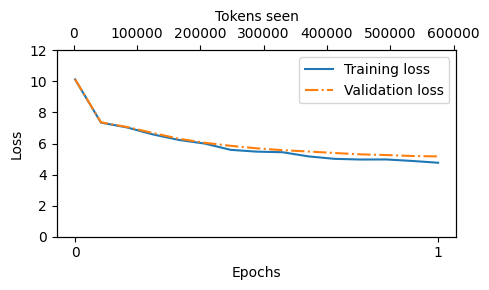

Saved cfg to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_temptest/epoch001_step0000293_cfg.json
Saved results to /content/drive/MyDrive/llm-from-scratch-drive/output/gpt2_temptest/epoch001_step0000293_results.json
FULL train loss: 4.677217900347547
FULL val loss: 5.023629752072421
AFTER TRAINING:
training full set loss: 4.677217900347547
validation full set loss: 5.023629752072421
Runtime: 00:06:16


{'final_train_loss_full_set': 4.677217900347547,
 'final_val_loss_full_set': 5.023629752072421,
 'tokens_seen': 575488,
 'global_step': 293,
 'runtime': '00:06:16'}

In [ ]:
run_training(cfg2)

## Experiment 1a: change batch size

In [ ]:
cfg2['run_name']="gpt2_val_abstracts_batcheq8_exp_abs1a_savetest"
cfg2['batch_size']=8
run_training(cfg2)

## Experiment 2: change try to use separate train and val sets  
will use the test set as the training set and the val set as the validation set


In [ ]:
cfg2['run_name']="gpt2_test_vs_val_abstracts"
print("This is weird because I am using the test file as the training file and the validation file as the validation file")
print("I am doing this because I want to have a reasonable testing file; I am using val file as both val and test file")
cfg2['training_file'] = str(DATA_DIR) + "/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_test_abstracts.txt"
cfg2['val_file'] = str(DATA_DIR) + "/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt"
cfg2['test_file']= str(DATA_DIR) + "/pubmed_abstracts_2005to2025ONLY_ERBB2_ABSTRACTS_getv7_english_val_abstracts.txt"
print(cfg2['training_file'])
print(cfg2['val_file'])

cfg2['num_epochs']=1 # only one epoch!
cfg2['batch_size']=8
run_training(cfg2)

## Experiment 1b: try alternate text
There are two rationales for this, one for this current work and one looking forward.
1. For this current work, it is interesting to see if different corpora perform significantly differently. Both are open source short stories (or part of a short story, truncated to be similar length to the first, for the second). This is just a basic check to see if reasonably similar sources vary much. Note also the concern that the test set is simply the last part of each story; this could easily have different characteristics than the rest of the text. Visual inspection doesn't reveal anything crazy (like if the last part were an author's note with different words and style than earlier) - but this could obviously be quantified by looking at word frequency or ngram frequency, etc. Simply comparing loss curves (both training and validation) for these two stories allows a quick and dirty examination of the effect of source material, when the source material is similar.

2. Longer run: rationale for this is that there is a concern that "the-verdict" text may have been part of the training set of GPT2. I found an "open source" text that is from ~2024/2025, so should not have been part of the ~2019 training of GPT2. This is not an issue here with training from scratch, but for continued pre-training and evaluation, it is. So the test here is to see if this alterate text performs similarly, so I can use it with continued pre-training experiments in the GPT2-small framework.  

3. I expect minor some minor differences; these texts are sylistically quite different in many ways, which can affect training.  


In [ ]:
cfg2['run_name']="gpt2_basic_exp_1b"
cfg2['description']="gpt2 with the adjusted watch story"
# "training_file": "/home/markb/llm-from-scratch/data/the-verdict.txt"
cfg2['training_file'] = PROJECT_ROOT +  "/data/The-watch-story-adj-smaller-2.txt"
run_training(cfg2)

### RESULTS  
1. Curves are quite similar with the two texts.  
2. With identical number of tokens seen, have somewhat larger training loss with the watch vs the verdict and slightly higher validation loss.  
3. Implications:  
    a. these texts do not appear to be some crazy texts that would mess with interpretation in these simple basic frameworks.  
    b. these texts can both be used later on for looking at the pre-trained models. The first text may have been part of the training set for the GPT2-small, but the second text is well after the training cutoff, so almost certainly was not.

## Experiment 2: change stride to do more training

In [ ]:
cfg2['run_name']="gpt2_basic_exp_2"
cfg2['stride']=128
cfg2

### run model

In [ ]:
run_training(cfg2)

## Experiment 3: make a much smaller model 2 layers, 2 heads, and emb_dim of 256

In [ ]:
cfg2['run_name']="gpt2_basic_exp_3"
cfg2['model_config']["emb_dim"]= 256         # Embedding dimension
cfg2['model_config']["n_heads"]= 2          # Number of attention heads
cfg2['model_config']["n_layers"]= 2          # Number of layers
cfg2

In [ ]:
run_training(cfg2)

## Experiment 4: do more epochs

In [ ]:
cfg2['run_name']="gpt2_basic_exp_4"
cfg2['num_epochs']=8

In [ ]:
run_training(cfg2)

## Experiment 5: mini-model, 2 layers, 4 heads per layer, 6 epochs

In [ ]:
cfg2['run_name']="gpt2_basic_exp_5"
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=2
cfg2['model_config']['n_heads']=4
cfg2

In [ ]:
run_training(cfg2)

## Experiment 6: mini-model, 2 layers, 8 heads per layer, epochs = 6

In [ ]:
cfg2['run_name']="gpt2_basic_exp_6"
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=2
cfg2['model_config']['n_heads']=8
cfg2

In [ ]:
run_training(cfg2)

## Experiment 7: mini-model, 8 layers, 2 heads per layer, 6 epochs

In [ ]:
cfg2['run_name']="gpt2_basic_exp_6"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
#cfg2['model_config']['emb_dim']=384
cfg2

In [ ]:
run_training(cfg2)

## Experiment 8: mini-model, 8 layers, 2 heads per layer, emb_dim=64 6 epochs

In [ ]:
## Experiment 7: mini-model, 8 layers, 2 heads per layer, 6 epochs
cfg2['run_name']="gpt2_basic_exp_6"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
cfg2['model_config']['emb_dim']=64
cfg2
run_training(cfg2)

## Experiment 9: mini-model, 8 layers, 2 heads per layer, emb_dim=64 12 epochs

In [ ]:

cfg2['run_name']="gpt2_basic_exp_9"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=12
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=2
cfg2['model_config']['emb_dim']=64
cfg2
run_training(cfg2)

## Experiment 10: mini-model, 8 layers, 8 heads per layer, emb_dim=768 6 epochs

In [ ]:

cfg2['run_name']="gpt2_basic_exp_10"
#cfg2['model_config']['weight_tying']=True
cfg2['num_epochs']=6
cfg2['model_config']['n_layers']=8
cfg2['model_config']['n_heads']=8
cfg2['model_config']['emb_dim']=768
cfg2
run_training(cfg2)